#EJERCICIO N°4 DE LA GUÍA DE AUTOENCODERS - CARLOS DOFFINY S-V
###Red Neuronal Variacional Autoencoder usando el data set [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion)

####Este data set consta de 60000 imágenes de entrenamiento y 10000 de prueba de 10 clases

Para este ejercicio se usó de guía la arquitectura [Variational Autoencoder](https://blog.keras.io/building-autoencoders-in-keras.html) que se presenta en ese link

In [1]:
import tensorflow as tf #Para el aprendizaje automático y entrenamiento de las redes
import numpy as np #Para los diferentes vectores y matrices que se usarán
import matplotlib.pyplot as plt #Para graficar

from tensorflow.keras.models import Model, Sequential #Para la construcción de los modelos
from tensorflow.keras.layers import Dense #Para la caja negra, que será llenada con capas densas
from tensorflow.keras import Input #Para el input de los modelos
from tensorflow.keras.utils import plot_model #Para mostrar el resumen de la arquitectura en bloques
from keras.datasets import fashion_mnist #Data set a utilizar
from keras.callbacks import ModelCheckpoint #Para los checkpoints
from keras import regularizers #Regularizers
from keras import backend as K 
from keras.utils import np_utils #Utils de numpy con Keras
import keras
from keras import layers
import gzip
%matplotlib inline
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization


##Validemos que estemos usando la GPU Tesla K80
####Ya que así se aumenta la capacidad de computo y por ende también la velocidad de procesamiento de la red

In [2]:
!nvidia-smi

Sun May 15 19:59:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Obtención y descarga del data set Fashion_Mnist


In [3]:
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data() #Descargando el data set, y separando los datos

##Dimensión de los grupos de datos

In [4]:
#Mostramos la dimensión de los grupos de datos expresados en:
# (Número de registros, pixeles de largo, pixeles de ancho)
print('Dimensión de la las imágenes de entrenamiento: ',x_train.shape)
print('\nDimensión de la los labels de entrenamiento: ',y_train.shape)
print('\nDimensión de las imágenes de validación: ',x_test.shape)
print('\nDimensión de los labels de validación: ',y_test.shape)

Dimensión de la las imágenes de entrenamiento:  (60000, 28, 28)

Dimensión de la los labels de entrenamiento:  (60000,)

Dimensión de las imágenes de validación:  (10000, 28, 28)

Dimensión de los labels de validación:  (10000,)


###Mostramos las primeras 25 imágenes del data set para verificar que su lectura haya sido correcta

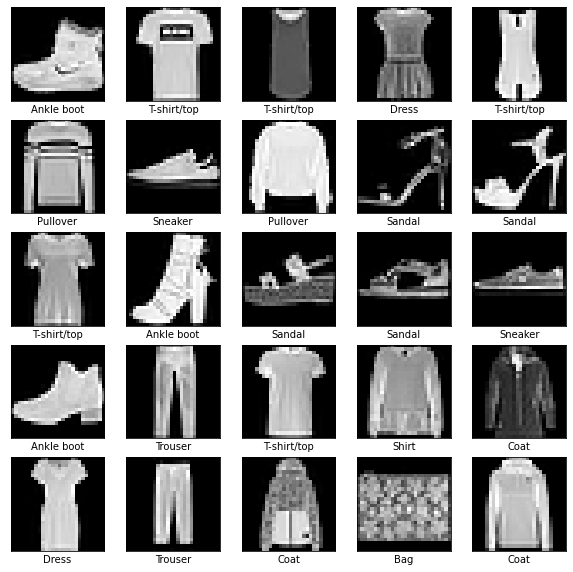

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] #Definición de las clases, las cuales pueden ser encontradas en el link del data set

plt.figure(figsize=(10,10)) #Dimensión de cada una de las imágenes
for i in range(25):
    plt.subplot(5,5,i+1) #Como se van a imprimir todas en el mismo plot, necesitamos construir subplots
    plt.xticks([]) #Eliminando las referencias de escalas en el eje de las abscisas 
    plt.yticks([]) #Eliminando las referencias de escalas en el eje de las ordenadas
    plt.grid(False) #Para no mostrar el grid de las gráficas
    plt.imshow(x_train[i],'gray') #Mostrar la imágen
    plt.xlabel(class_names[y_train[i]]) #Mostrar el título de la imágen en el eje de las abscisas
plt.show() #Imprimir el plot completo

##Normalizar Data
####Con valores entre 0 y 1, y solo para la data de entrada

In [6]:
x_train = x_train / 255 #Normalizando data de entrenamiento
x_test = x_test / 255 #Normalizando data de validación

####Se impreme la primera imágen para verificar que todo sigue bien con la data recién normalizada

Text(0.5, 0, 'Ankle boot')

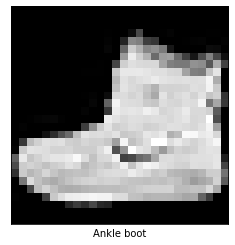

In [7]:
plt.xticks([]) #Eliminando las referencias de escalas en el eje de las abscisas 
plt.yticks([]) #Eliminando las referencias de escalas en el eje de las ordenadas
plt.grid(False) #Para no mostrar el grid de las gráficas
plt.imshow(x_train[0],'gray') #Mostrar la primera imágen con el data set recién normalizado
plt.xlabel(class_names[y_train[0]]) #Mostrar el título de la imágen en el eje de las abscisas

##Reshape de las imágenes
###Ya que los autoencoders solo aceptan vectores de entrada en sus redes densas, no matrices

In [8]:
x_train = x_train.reshape(60000,28*28) #Como las redes densas solo permiten datos en forma de vectores, y no matrices, hay que convertir la matriz en vector
x_test = x_test.reshape(10000,28*28)

print('Dimensión de la las imágenes de entrenamiento: ',x_train.shape) #Nueva dimensión de la data de entrenamiento
print('\nDimensión de la las imágenes de validación: ',x_test.shape) #Nueva dimensión de la data de validación

Dimensión de la las imágenes de entrenamiento:  (60000, 784)

Dimensión de la las imágenes de validación:  (10000, 784)


##One hot encoding
####Esto solo se hace con la data de salida (Labels)

In [9]:
#No es conveniente que el target sea un vector unidimensional, lo recomendado es que como tenemos 10 clases o tipos de valores diferentes,
# entonces se haga una matriz de 10 columnas (el num de las clases), y en donde el valor almacenado será 0 en cada una de ellas, menos en
# la clase a la cual pertenezca la data de entrada en esa fila, que tendrá en su caso un 1. Esto es lo que se conoce como vector 
#one hot-encoding. Esto hace que el target sea esta nueva matriz, y no el vector unidimensional de antes.

y_train2 = np_utils.to_categorical(y_train) #Matriz de one hot-encoding de los datos de entrenamiento
y_test2 = np_utils.to_categorical(y_test) #Matriz de one hot-encoding de los datos de validación

print('La nueva dimensión del target de entrenamiento es: ',y_train2.shape)
print('\nLa nueva dimensión del target de validación es: ',y_test2.shape)

La nueva dimensión del target de entrenamiento es:  (60000, 10)

La nueva dimensión del target de validación es:  (10000, 10)


In [10]:
print(y_train) #ANTES

[9 0 0 ... 3 0 5]


In [11]:
print(y_train2) #AHORA

[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##Dimensión de entrada y número de clases

In [12]:
input_dim = x_train.shape[1:] #Dimensión de entrada (cantidad de características de la data entrante, es decir, variables de entrada)

num_class = y_train2.shape[1] #Número de clases (cantidad de neuronas de salidas) o clases a clasificar


print('Dimensión de entrada:', input_dim)
print('Número de clases:', num_class)

Dimensión de entrada: (784,)
Número de clases: 10


##Arquitectura del Autoencoder

###Construcción del encoder

In [13]:
original_dim = input_dim[0] #Dimensión de entrada
intermediate_dim = 64 #Dimensión de la capa intermedia entre la primera del encoder con la latente
latent_dim = 2 #Construiremos un espacio latente de dos dimensiones

inputs = keras.Input(shape=(original_dim,)) #Capa de entrada al encoder
h = layers.Dense(intermediate_dim, activation='relu')(inputs) #Capa intermedia
z_mean = layers.Dense(latent_dim)(h) #Primer parámetro de distribución de la capa latente
z_log_sigma = layers.Dense(latent_dim)(h) #Segundo parámetro de distribución de la capa latente

###Construcción de los puntos del espacio latente

In [14]:
def sampling(args): #Función para muestrear los puntos del espacio latente
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1) #Epsilon es un tensor
    return z_mean + K.exp(z_log_sigma) * epsilon #Fórmula de formación de los puntos con distribución normal en el espacio latente

z = layers.Lambda(sampling)([z_mean, z_log_sigma]) #Construcción de los puntos en el espacio latente

###Modelos de los elementos del autoencoder

In [15]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder') #Creación del encoder desde la capa inicial, a la capa latente

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling') #Primera capa del decoder
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs) #Capa intermedia entre la latente y la final
outputs = layers.Dense(original_dim, activation='sigmoid')(x) #Última capa 
decoder = keras.Model(latent_inputs, outputs, name='decoder') #Creación del decoder, desde la capa latente hasta la última capa

# instantiate VAE model
outputs = decoder(encoder(inputs)[2]) 
vae = keras.Model(inputs, outputs, name='vae_mlp') #Creación del Autoencoder Variacional, incluyendo los 3 elementos de este

##Resúmenes de los modelos

###Encoder

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           50240       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            130         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2)            130         ['dense[0][0]']                  
                                                                                            

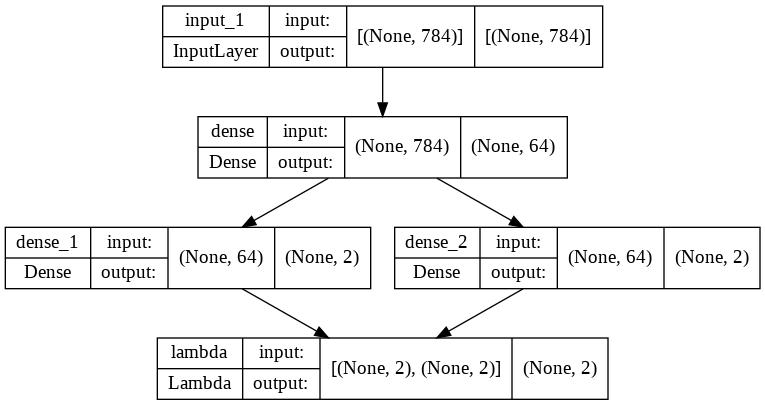

In [16]:
encoder.summary() #Resumen del encoder
plot_model(encoder, to_file='autoencoder.jpg', show_shapes=True) #Resumen del encoder tipo plot en imágen

###Decoder

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 64)                192       
                                                                 
 dense_4 (Dense)             (None, 784)               50960     
                                                                 
Total params: 51,152
Trainable params: 51,152
Non-trainable params: 0
_________________________________________________________________


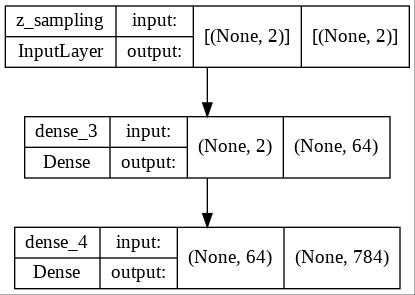

In [17]:
decoder.summary() #Resumen del decoder
plot_model(decoder, to_file='autoencoder.jpg', show_shapes=True) #Resumen del decoder tipo plot en imágen

###Variational autoencoder

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               50500     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               51152     
                                                                 
Total params: 101,652
Trainable params: 101,652
Non-trainable params: 0
_________________________________________________________________


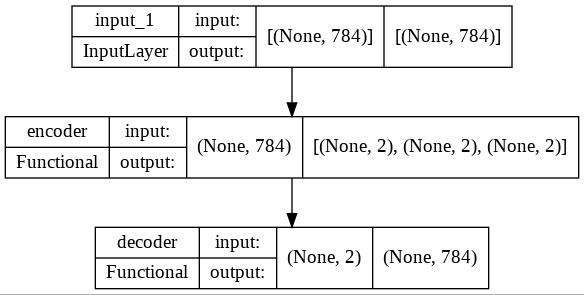

In [18]:
vae.summary() #Resumen del VAE
plot_model(vae, to_file='autoencoder.jpg', show_shapes=True) #Resumen del VAE tipo plot en imágen

##Distribución de los datos previo al entrenamiento
En el espacio latente

In [19]:
x_test_preEncoded = encoder.predict(x_test, batch_size=32) #Predicción del modelo antes de ser entrenado
x_test_preEncoded = np.array(x_test_preEncoded) #Convirtiendo esa predicción en un numpy array

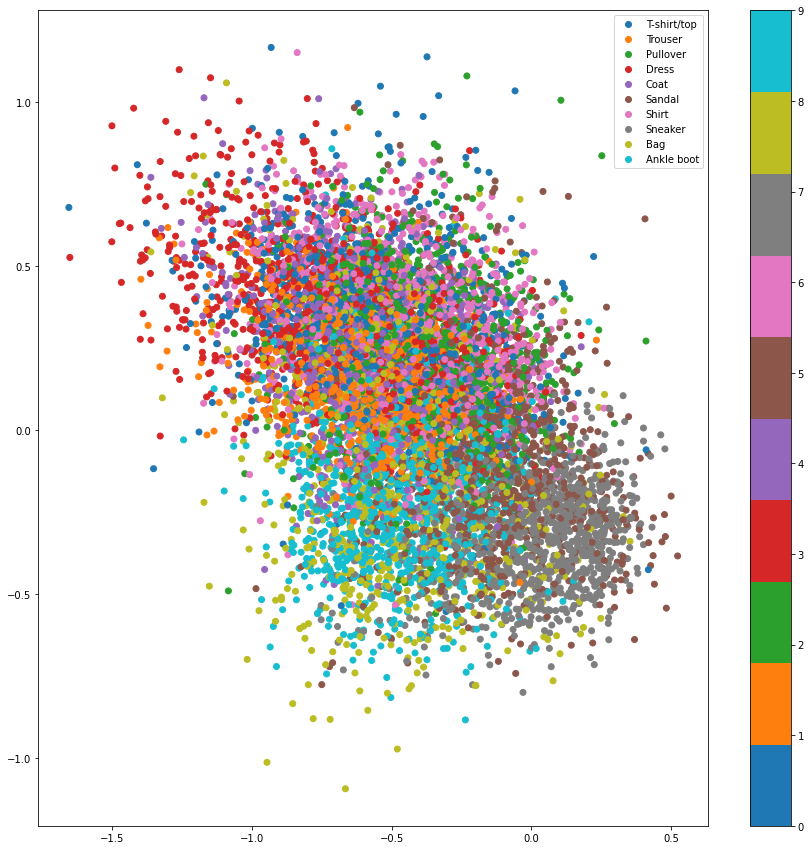

In [20]:
from matplotlib.colors import ListedColormap #Para los colores

plt.figure(figsize=(15,15)) #Tamaño de la gráfica
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] #Clases
colors = ListedColormap(['tab:blue','tab:orange','tab:green', 'tab:red','tab:purple','tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']) #Colores
scatter = plt.scatter(x_test_preEncoded[0, :,0], x_test_preEncoded[0,:, 1], c=y_test, cmap=colors) #Gráfica de los puntos en el espacio latente
plt.legend(handles=scatter.legend_elements()[0], labels=classes) #Leyenda
plt.colorbar() #Barra lateral de colores


##Estableciendo el optimizador y función de pérdida del modelo

In [21]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs) #La pérdida de reconstrucción del modelo
reconstruction_loss *= original_dim #Multiplicándolo por la dimensión de entrada
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma) #Pérdida del espacio latente
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss) #La pérdida del modelo será la suma de la pérdida del encoder más el decoder 
vae.add_loss(vae_loss) #Asigando la pérdida del modelo
vae.compile(optimizer='adam') #Asignando el optimizador

##Entrenamiento del Variational Autoencoder

In [22]:
vae.fit(x_train, x_train,
        epochs=200,
        batch_size=64,
        validation_data=(x_test, x_test)) #Asignando las épocas, tamaño del lote y data de entrenamiento y validación, la cual es la misma ya que deberá ser reconstruido

Epoch 1/200
938/938 [==============================] - 11s 10ms/step - loss: 307.2671 - val_loss: 280.8458
Epoch 2/200
938/938 [==============================] - 5s 5ms/step - loss: 276.7944 - val_loss: 275.8022
Epoch 3/200
938/938 [==============================] - 5s 6ms/step - loss: 272.5963 - val_loss: 271.9222
Epoch 4/200
938/938 [==============================] - 5s 5ms/step - loss: 269.5072 - val_loss: 272.1393
Epoch 5/200
938/938 [==============================] - 5s 5ms/step - loss: 267.4666 - val_loss: 268.5320
Epoch 6/200
938/938 [==============================] - 5s 5ms/step - loss: 266.0538 - val_loss: 266.3595
Epoch 7/200
938/938 [==============================] - 5s 5ms/step - loss: 264.7985 - val_loss: 265.3709
Epoch 8/200
938/938 [==============================] - 5s 5ms/step - loss: 263.8674 - val_loss: 264.7084
Epoch 9/200
938/938 [==============================] - 5s 5ms/step - loss: 263.0404 - val_loss: 265.0529
Epoch 10/200
938/938 [==============================]

##Distribución de los datos después del entrenamiento 
En el espacio latente

In [23]:
x_test_encoded = encoder.predict(x_test, batch_size=32)#Predicción del modelo antes de ser entrenado
x_test_encoded = np.array(x_test_encoded) #Convirtiendo esa pérdida en un numpy array

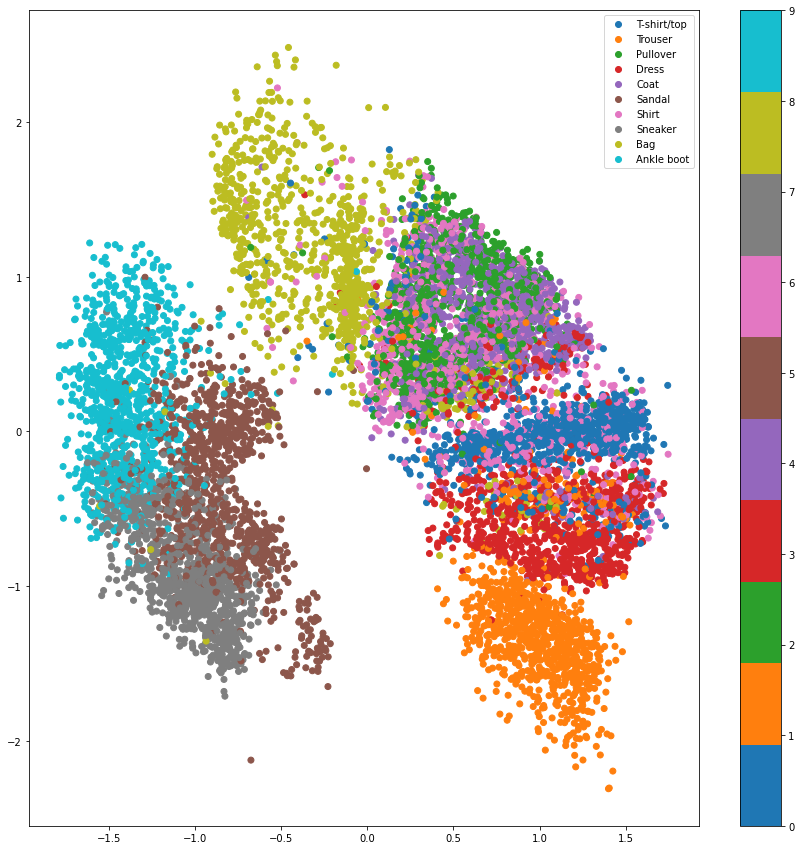

In [24]:
from matplotlib.colors import ListedColormap #Para los colores

plt.figure(figsize=(15,15)) #Tamaño de la imágen
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] #Clases
colors = ListedColormap(['tab:blue','tab:orange','tab:green', 'tab:red','tab:purple','tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']) #Colores
scatter = plt.scatter(x_test_encoded[0, :,0], x_test_encoded[0,:, 1], c=y_test, cmap=colors) #Graficar los puntos del espacio latente
plt.legend(handles=scatter.legend_elements()[0], labels=classes) #Leyenda
plt.colorbar() #Barra lateral de colores


##Capacidad de generar imágenes a partir del decoder

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


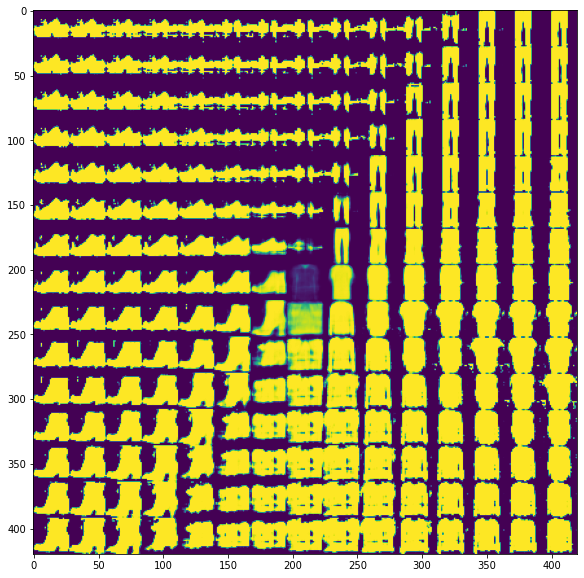

In [28]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

#Análisis de Componentes Principales (PCA)

In [29]:
from sklearn.decomposition import PCA #Importando el PCA

In [35]:
pca = PCA(n_components=2) #Creando el PCA bidimensional

dist = pca.fit_transform(x_train) #Entrenando el modelo PCA

dist.shape #Tamaño. 60000 imágenes bidimensionales

(60000, 2)

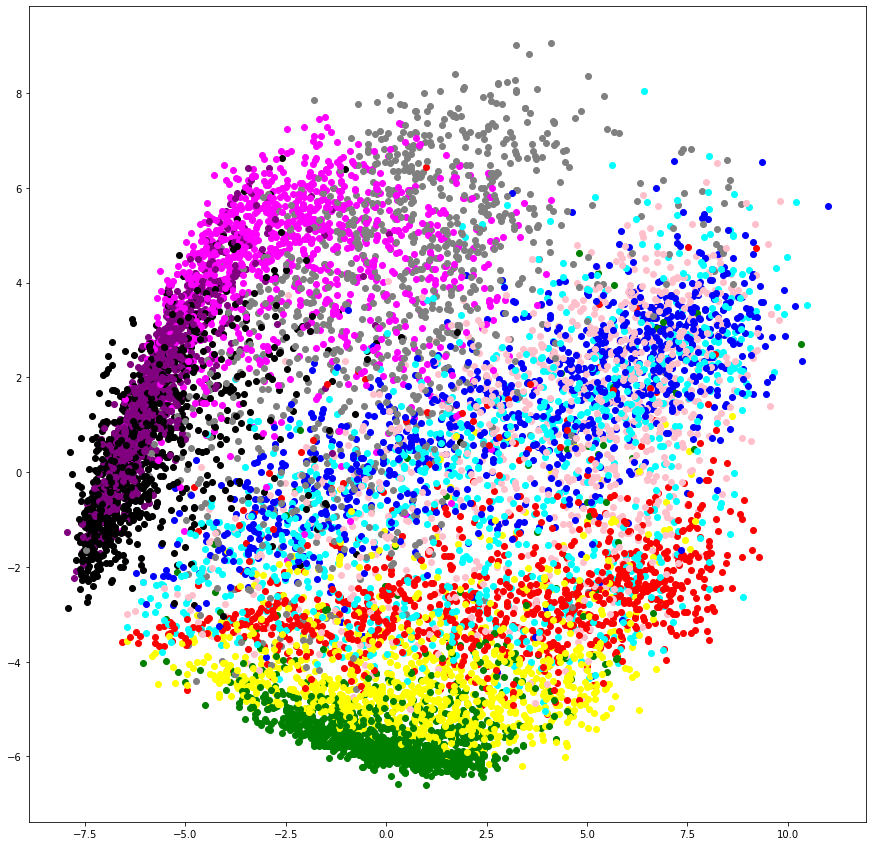

In [34]:
plt.figure(figsize=(15,15)) #Tamaño de la imagen

colors2 = ['red', 'green', 'blue', 'yellow', 'pink', 'black', 'cyan', 'purple', 'gray', 'magenta'] #Colores de las clasess


for i in range(10000): #Graficaremos los puntos solo de las primeras 10000 imágenes

    plt.scatter(dist[i,0], dist[i,1], color=colors2[y_train[i]]) #Graficando los puntos